In [1]:
from amm import amm
import numpy as np
from scipy.stats import norm

import matplotlib.pyplot as plt
# plt.style.use('paper.mplstyle')

import seaborn as sns
sns.set_theme(style="ticks")

import statsmodels.api as sm
import matplotlib.ticker as mtick
import pickle
import pandas as pd

# Helper functions

In [2]:
def plot_hist(returns):
    
    zeta = 0.05
    alpha = 0.05
    
    sns.kdeplot(returns)
    
    p = np.mean(returns >= zeta)
    var = np.quantile(returns, alpha)
    cvar = float(np.sum(returns * (returns <= var)) / np.sum(returns <= var)) / (1 - alpha)

    plt.axvline(var, c='y', linestyle='--', label=f'VaR={var:4.2}')
    plt.axvline(cvar, c='r', linestyle='--', label=f'CVaR={cvar:4.2}')
    plt.axvline(zeta, c='g', linestyle='--', label=f'P={p}')
    plt.legend()

In [3]:
def plot_2d(returns):
    
    n_assets = returns.shape[1]
    
    fig, ax = plt.subplots(nrows=n_assets, ncols=n_assets, figsize=(2 * n_assets + 2, 2 * n_assets), constrained_layout=True)
    fig.suptitle('2D marginals', fontsize=20)

    for i in range(n_assets):
        for j in range(n_assets):
            if i < j:
                ax[i][j].hist2d(returns[:, i], returns[:, j], bins=50, range=[[-0.3, 0.3], [-0.3, 0.3]], cmap='viridis')
            if i > j:
                fig.delaxes(ax[i][j])
        sns.kdeplot(data=returns[:, i], ax=ax[i][i], fill=True, label='train')
        ax[i][i].legend()

# Generate returns

In [4]:
T = 60
Rx = 100.
Ry = 1000.
batch_size = 1_000

kappa = [0.25, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]
sigma = [1, 0.3, 0.5, 1.5, 1.75, 2, 2.25]
p = [0.35, 0.3, 0.34, 0.33, 0.32, 0.31, 0.3]
phi = np.repeat(0.03, 7)

In [5]:
''' Initial reserves '''
Rx0   = np.repeat(Rx, len(kappa))
Ry0   = np.repeat(Ry, len(kappa))

pools = amm(Rx=Rx0, Ry=Ry0, phi=phi)

xs_0 = np.repeat(1., len(kappa))
l = pools.swap_and_mint(xs_0)
end_pools, Rx_t, Ry_t, v_t, event_type_t, event_direction_t = pools.simulate(kappa, p, sigma, T=T, batch_size=batch_size)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 313.51it/s]


In [6]:
x_T = np.array([pool.burn_and_swap(l) for pool in end_pools])
log_ret = np.log(x_T)
Y = pd.DataFrame(log_ret)
Y

,0,1,2,3,4,5,6
0,0.135534,0.183217,0.095405,0.159111,0.042193,0.167867,0.065405
1,0.250300,0.169142,0.226505,0.035372,0.154099,0.197052,0.101731
2,0.094729,0.138524,0.093321,0.178307,0.111987,-0.045499,0.006696
3,0.139684,-0.020188,0.012813,0.123774,0.038997,0.056983,0.002647
4,0.096947,0.054118,-0.059892,-0.012525,0.084788,-0.030741,-0.063909
...,...,...,...,...,...,...,...
995,0.182117,0.065271,0.064691,0.022631,0.231271,-0.105157,0.078943
996,0.107050,0.053644,0.249193,0.014157,0.205537,-0.082400,-0.014439
997,0.221808,0.202440,0.062786,0.134531,0.069830,0.001123,0.036832
998,0.016440,-0.025609,0.079409,0.069953,-0.088147,-0.042917,-0.095578


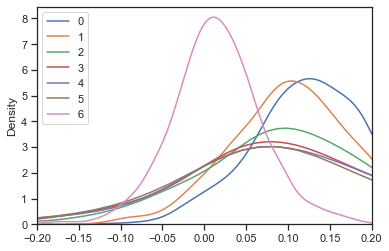

In [7]:
# 1d marginals on top of each other

for i in range(log_ret.shape[1]):
    sns.kdeplot(log_ret[:, i], label=i)
    
plt.xlim((-0.2, 0.2))
plt.legend()

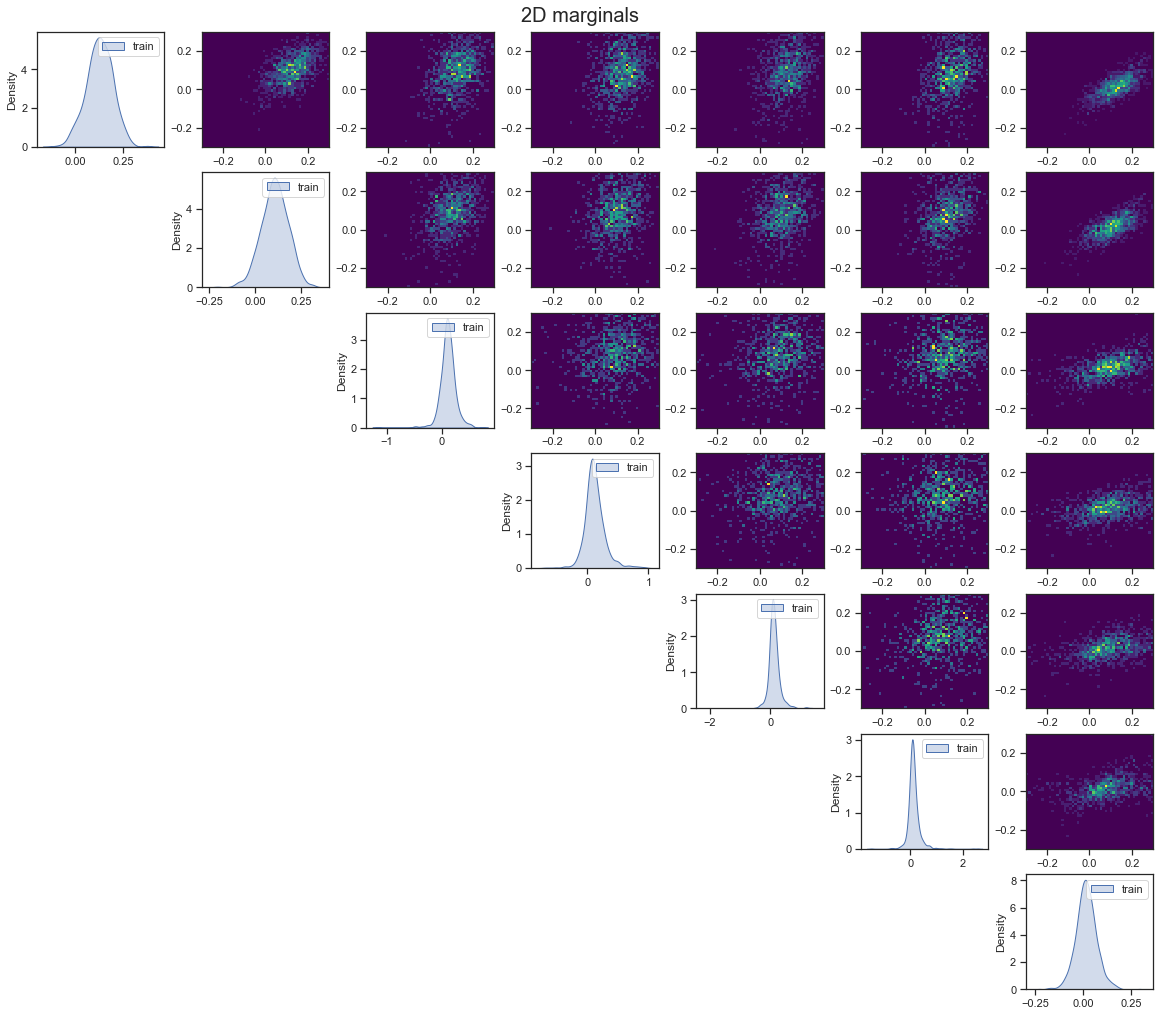

In [8]:
plot_2d(log_ret)

# Average of quantiles vs. quantiles of averages

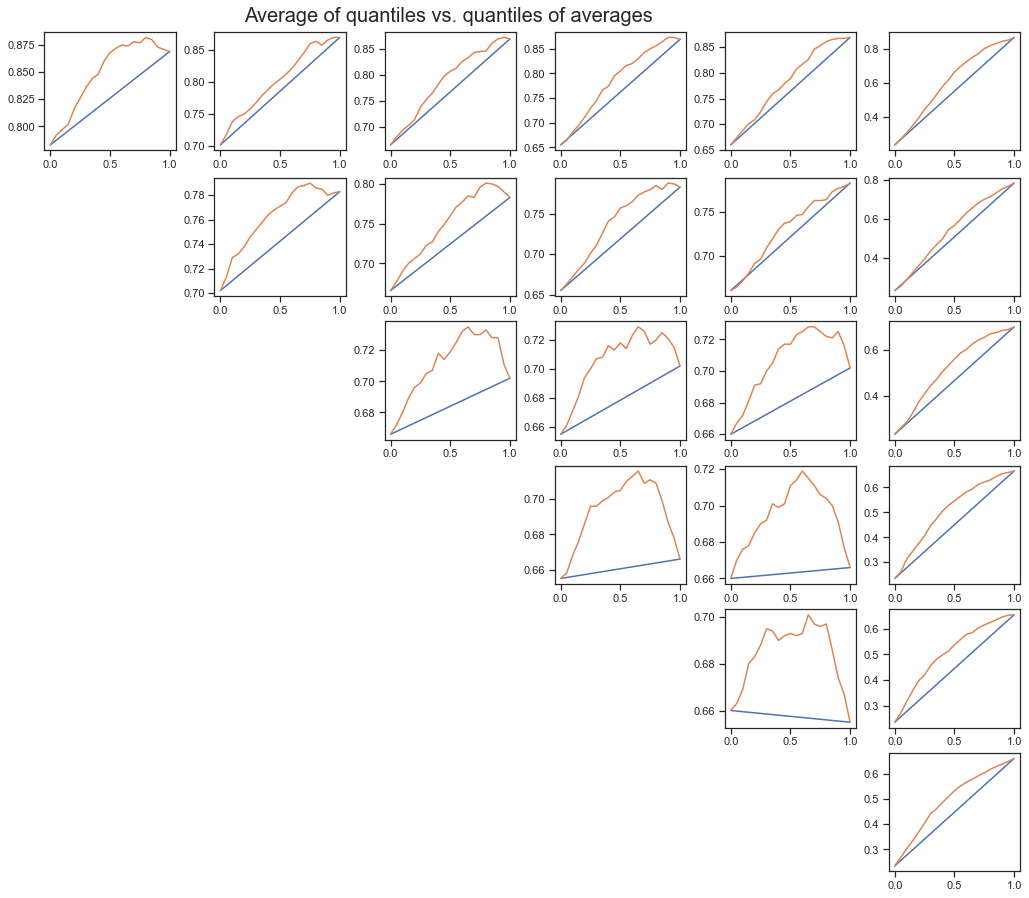

In [9]:
n_assets = 7

fig, ax = plt.subplots(nrows=n_assets, ncols=n_assets, figsize=(2 * n_assets + 2, 2 * n_assets), constrained_layout=True)
fig.suptitle('Average of quantiles vs. quantiles of averages', fontsize=20)

for i in range(n_assets):
    for j in range(n_assets):
        if i < j:
            q0, q1 = np.mean(log_ret[:, i] >= 0.05), np.mean(log_ret[:, j] >= 0.05)

            ws = np.linspace(0, 1, 21)
            ps0 = ws * q0 + (1 - ws) * q1
            ps1 = np.mean(ws[:, None] @ log_ret[:, i][None, :] + ((1 - ws[:, None]) @ log_ret[:, j][None, :]) >= 0.05, axis=1)

            ax[i][j].plot(ws, ps0)
            ax[i][j].plot(ws, ps1)
            
        if i >= j:
            fig.delaxes(ax[i][j])


# Correlation of returns

In [10]:
df = pd.DataFrame(log_ret)
mean = pd.DataFrame(df.mean(axis=0)).T
display(mean.style.background_gradient(cmap='coolwarm', axis=None))
corr = df.corr()
display(corr.style.background_gradient(cmap='coolwarm', axis=None))

,0,1,2,3,4,5,6
0,0.126483,0.104489,0.103747,0.116332,0.115276,0.119614,0.014861


,0,1,2,3,4,5,6
0,1.000000,0.506515,0.310390,0.175153,0.179934,0.144860,0.704401
1,0.506515,1.000000,0.341724,0.188487,0.169610,0.169798,0.685396
2,0.310390,0.341724,1.000000,0.105565,0.136619,0.051818,0.421732
3,0.175153,0.188487,0.105565,1.000000,0.123470,0.064883,0.301061
4,0.179934,0.169610,0.136619,0.123470,1.000000,0.052020,0.267299
5,0.144860,0.169798,0.051818,0.064883,0.052020,1.000000,0.178066
6,0.704401,0.685396,0.421732,0.301061,0.267299,0.178066,1.000000


# Optimization with riskfolio

In [11]:
import riskfolio as rp
import pandas as pd

Portfolio weights:


,0,1,2,3,4,5,6
weights,0.71721,0.153992,2.444891e-14,0.12062,0.003378,0.0048,4.050767e-15


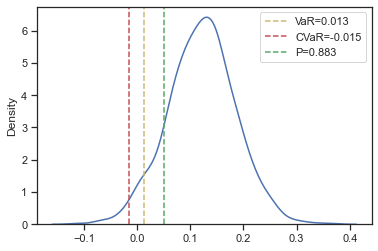

In [12]:
# Building the portfolio object
port = rp.Portfolio(returns=Y)

# Calculating optimal portfolio

# Select method and estimate input parameters:

method_mu='hist' # Method to estimate expected returns based on historical data.
method_cov='hist' # Method to estimate covariance matrix based on historical data.

port.assets_stats(method_mu=method_mu, method_cov=method_cov, d=0.94)

# Estimate optimal portfolio:

model='Classic' # Could be Classic (historical), BL (Black Litterman) or FM (Factor Model)
rm = 'CVaR' # Risk measure used, this time will be variance
obj = 'MinRisk' # Objective function, could be MinRisk, MaxRet, Utility or Sharpe
hist = True # Use historical scenarios for risk measures that depend on scenarios
rf = 0 # Risk free rate
l = 0 # Risk aversion factor, only useful when obj is 'Utility'

weights = port.optimization(model=model, rm=rm, obj=obj, rf=rf, l=l, hist=hist)

print("Portfolio weights:")
display(weights.T)

portfolio_returns = log_ret @ weights
portfolio_returns = portfolio_returns.to_numpy().T[0]
plot_hist(portfolio_returns)

# Optimization by hand

1. Adjust code from `riskfolio/src/Portfolio.py`, and incorporate our constraints P(ret >= 0.5) >= 0.7
2. Check if this constraint can be accommodated by riskfolio library

## Linear inequality with second-order constraints

- consider $a^T x \leq b$, with $a \sim \mathcal{N}(\bar{a}, \Sigma)$
- then $a^T x-b \sim \mathcal{N}\left(\bar{a}^T x-b, x^T \Sigma x\right)$
- hence
$$
\operatorname{Prob}\left(a^T x \leq b\right)=\Phi\left(\frac{b-\bar{a}^T x}{\sqrt{x^T \Sigma x}}\right)
$$
- and so
$$
\operatorname{Prob}\left(a^T x \leq b\right) \geq \eta \Longleftrightarrow b-\bar{a}^T x \geq \Phi^{-1}(\eta)\left\|\Sigma^{1 / 2} x\right\|_2
$$
a second-order cone constraint for $\eta \geq 0.5$ (i.e., $\Phi^{-1}(\eta) \geq 0$ )

Objective: 13.793511887327268
Portfolio weights:


,0,1,2,3,4,5,6
0,0.717209,0.153997,4.515718e-07,0.120616,0.003377,0.0048,1.374573e-08


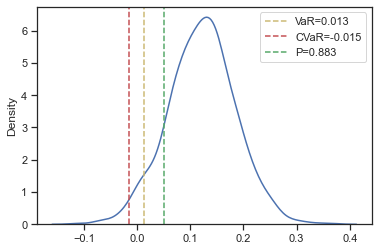

In [84]:
# pseudocode:
# reference file: riskfolio/src/Portfolio.py

import cvxpy as cp
import numpy as np
from scipy.linalg import sqrtm

returns = log_ret
alpha = 0.05
zeta = 0.85

n_returns, n_assets = returns.shape

weights = cp.Variable((n_assets,))
X = returns @ weights

Z = cp.Variable((n_returns,))
var = cp.Variable((1,))
cvar = var + 1 / (alpha * n_returns) * cp.sum(Z)

constraints = [cp.sum(weights) == 1., weights <= 1., weights * 1000 >= 0]

# CVaR constraints
constraints += [Z * 1000 >= 0, Z * 1000 >= -X * 1000 - var * 1000]

# # lower bound: average of emp cdf:
# # might not be a valid constraint!
# emp_cdf_005 = np.mean(log_ret >= 0.05, axis=0)
# constraints += [emp_cdf_005 @ weights * 1000 >= zeta * 1000]

# normal approximation with SOC constraint
mean, cov = log_ret.mean(axis=0), df.cov().to_numpy()
sqrtcov = sqrtm(cov)
constraints += [cp.SOC((-0.05 + mean @ weights) / norm.ppf(zeta), sqrtcov @ weights)]

# naive idea for the return constraint:
# constraints += [cp.sum(returns @ weights >= 0.05) >= 0.7 * n_returns]

objective = cp.Minimize(cvar * 1000)

# possible solvers: "ECOS", "SCS", "OSQP", "CVXOPT"
prob = cp.Problem(objective, constraints)
result = prob.solve(solver="SCS")

print(f"Objective: {result}")

portfolio_weights = weights.value
portfolio_returns = returns @ portfolio_weights

print("Portfolio weights:")
display(pd.DataFrame(portfolio_weights).T)
plot_hist(portfolio_returns)